In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, r2_score, mean_absolute_error, classification_report, plot_confusion_matrix, accuracy_score
from scipy.stats import reciprocal, randint
from sklearn.linear_model import LinearRegression,  Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

# Exploración

In [2]:
df = pd.read_csv('winequality-white.csv', sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [3]:
df.quality.value_counts(sort=False)

4     163
8     175
5    1457
9       5
6    2198
3      20
7     880
Name: quality, dtype: int64

In [4]:
X = df.drop(columns='quality')
sc = StandardScaler()
X = sc.fit_transform(X)
y = df.quality

In [5]:
y_list = [['Calidad con todos los valores', y],
          ['Calidad con 2 clases', pd.cut(y, bins=[0, 5.5, 10], labels=[0, 1])],
          ['Calidad con 3 clases uniforme', pd.cut(y, bins=[0, 4.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 3 clases no uniforme', pd.cut(y, bins=[0, 5.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 4 clases', pd.cut(y, bins=[0, 4.5, 5.5, 6.5, 10], labels=[0, 1, 2, 3])]
         ]
y_list[0][1] = y_list[0][1].map({3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:8})

In [6]:
#Función para determinar y graficar las variables independientes mas importantes
def plot_feature_importances(clf, X_train, y_train=None, top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    clf.fit(X_train, y_train)
    feat_imp = pd.DataFrame({'importance': clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

# Modelos simples

## Regresión Logística

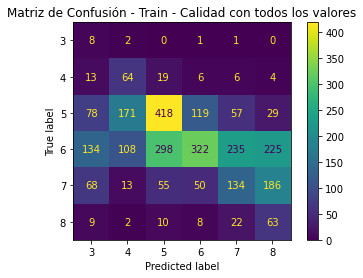

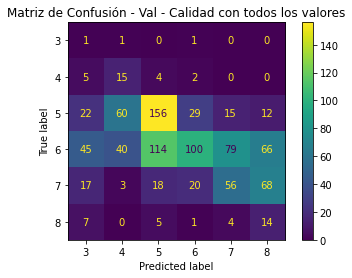

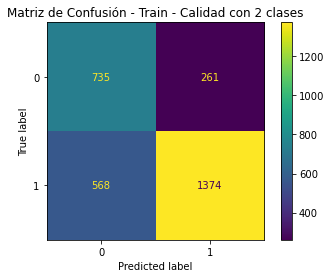

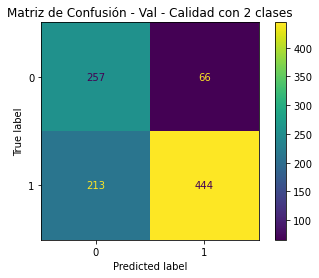

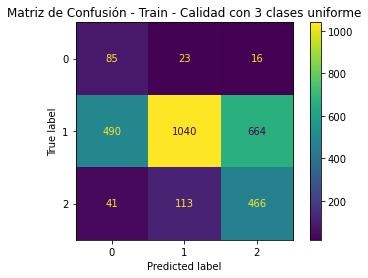

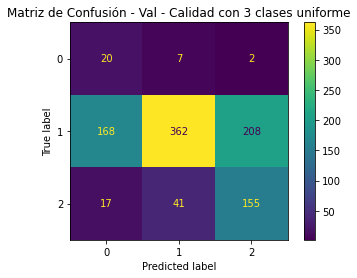

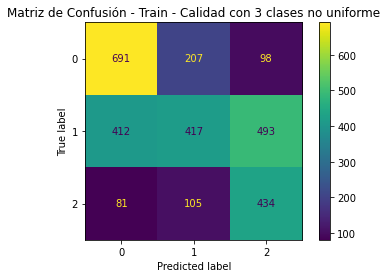

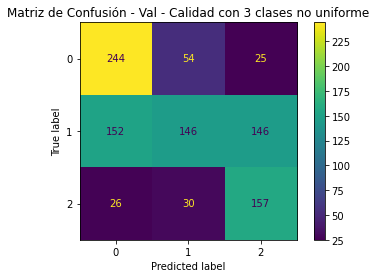

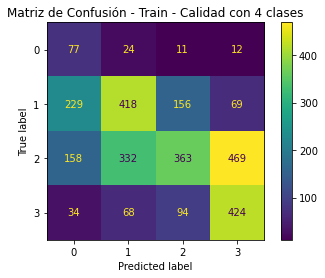

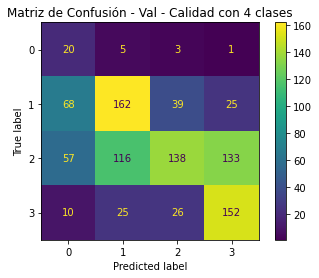

Wall time: 4min 21s


In [7]:
%%time
list_lr = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    log_est = LogisticRegression(class_weight='balanced', 
                                                multi_class='multinomial',
                                                solver='newton-cg',
                                                fit_intercept=True, 
                                                penalty='l2',
                                                max_iter=500)

    dists = {'C': reciprocal(1e-4, 1e4)}

    lr = RandomizedSearchCV(log_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    lr.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(lr, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(lr, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_lr.append([Y[0], 
                   f1_score(y_train, lr.predict(X_train), average='macro'),
                   f1_score(y_val, lr.predict(X_val), average='macro'),
                   accuracy_score(y_train, lr.predict(X_train)),
                   accuracy_score(y_val, lr.predict(X_val)),
                   f1_score(y_train, lr.predict(X_train), average=None),
                   f1_score(y_val, lr.predict(X_val), average=None)]
                  )

In [8]:
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:,.4f}'.format
labels_metrics = ['Variables', 'F1 Score Train', 'F1 Score Val','Accuracy Train','Accuracy Test','F1 Train Scores for each class', 'F1 Validation Scores for each class']
df_metrics_lr = pd.DataFrame(list_lr, columns=labels_metrics)
df_metrics_lr

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.2758,0.2616,0.3434,0.3490,"[0.04968944099378882, 0.2711864406779661, 0.5, 0.3522975929978118, 0.2788761706555671, 0.2028985...","[0.02, 0.20689655172413793, 0.5279187817258884, 0.33500837520938026, 0.33333333333333337, 0.1465..."
1,Calidad con 2 clases,0.7038,0.7045,0.7178,0.7153,"[0.6394084384515006, 0.7682415431926195]","[0.648171500630517, 0.7609254498714653]"
2,Calidad con 3 clases uniforme,0.4582,0.4460,0.5415,0.5480,"[0.22972972972972971, 0.6172106824925816, 0.5277463193657984]","[0.17094017094017094, 0.6306620209059234, 0.5363321799307957]"
3,Calidad con 3 clases no uniforme,0.5227,0.5562,0.5248,0.5582,"[0.6339449541284404, 0.4066309117503656, 0.5276595744680851]","[0.65503355704698, 0.43323442136498513, 0.5804066543438078]"
4,Calidad con 4 clases,0.4101,0.4401,0.4364,0.4816,"[0.24758842443729903, 0.4877479579929988, 0.3730729701952724, 0.5319949811794228]","[0.21739130434782608, 0.5382059800664452, 0.4246153846153846, 0.5801526717557252]"


## Máquina de Soporte Vecotrial (SVM)

{'C': 37.34299352416204, 'gamma': 0.5400862781742977}


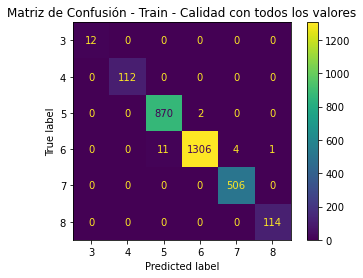

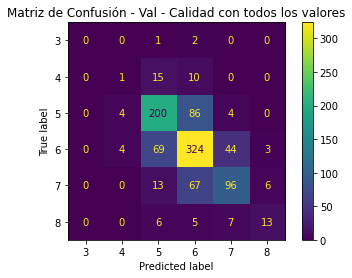

{'C': 3.9403900018467555, 'gamma': 0.16369303050608516}


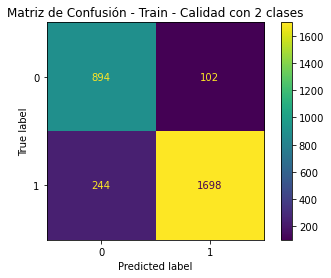

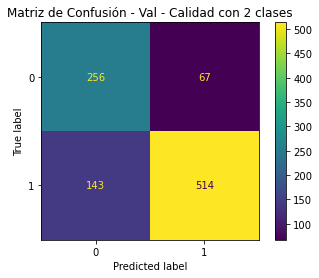

{'C': 468.83812259458847, 'gamma': 0.4787744976069652}


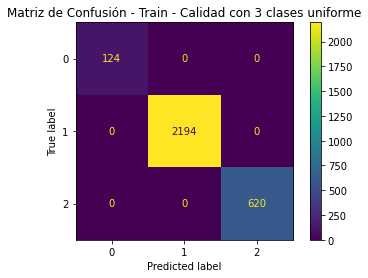

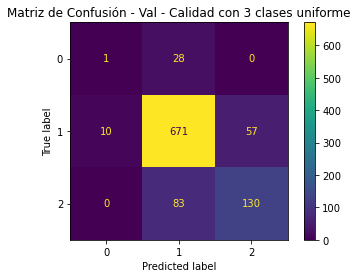

{'C': 1.137824602039525, 'gamma': 0.7753662994324833}


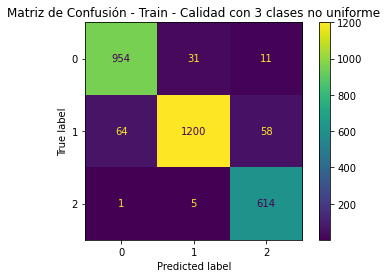

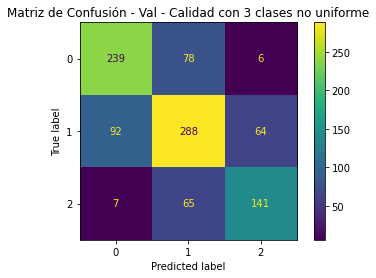

{'C': 199.3992514681481, 'gamma': 0.5846851945059217}


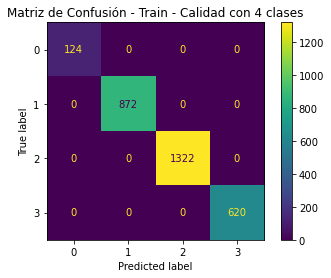

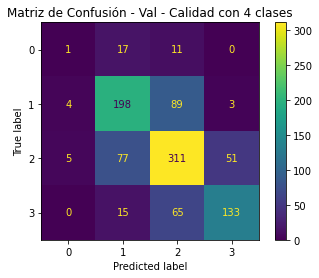

Wall time: 39min 16s


In [9]:
%%time
list_svm = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_est = SVC(kernel='rbf', class_weight='balanced')

    dists = {'gamma':reciprocal(0.01, 100),'C': reciprocal(1e-4, 1e4)}

    svm = RandomizedSearchCV(svm_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    svm.fit(X_train, y_train)
    print(svm.best_params_)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm.append([Y[0], 
                   f1_score(y_train, svm.predict(X_train), average='macro'),
                   f1_score(y_val, svm.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm.predict(X_train)),
                   accuracy_score(y_val, svm.predict(X_val)),
                   f1_score(y_train, svm.predict(X_train), average=None),
                   f1_score(y_val, svm.predict(X_val), average=None)]
                   )

In [10]:
df_metrics_svm = pd.DataFrame(list_svm, columns=labels_metrics)
df_metrics_svm

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.9962,0.4140,0.9939,0.6469,"[1.0, 1.0, 0.9925841414717627, 0.9931558935361217, 0.9960629921259843, 0.9956331877729258]","[0.0, 0.05714285714285715, 0.6688963210702342, 0.6908315565031984, 0.5765765765765766, 0.4905660..."
1,Calidad con 2 clases,0.8727,0.7698,0.8822,0.7857,"[0.837863167760075, 0.9075360769641903]","[0.7091412742382273, 0.8303715670436187]"
2,Calidad con 3 clases uniforme,1.0000,0.5276,1.0000,0.8184,"[1.0, 1.0, 1.0]","[0.05, 0.8828947368421053, 0.65]"
3,Calidad con 3 clases no uniforme,0.9425,0.6822,0.9421,0.6816,"[0.9468982630272953, 0.9382329945269742, 0.9424405218726017]","[0.7231467473524961, 0.6582857142857143, 0.6650943396226415]"
4,Calidad con 4 clases,1.0000,0.5128,1.0000,0.6561,"[1.0, 1.0, 1.0, 1.0]","[0.05128205128205129, 0.6589018302828619, 0.6760869565217391, 0.6649999999999999]"


## Árbol de Decisión

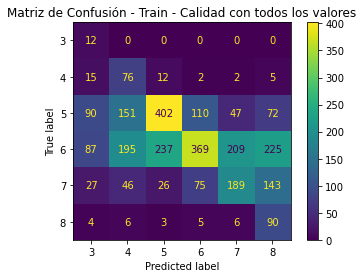

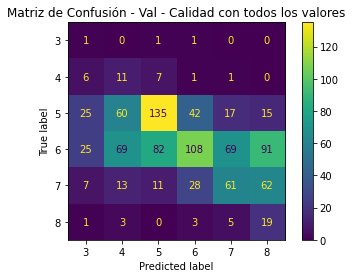

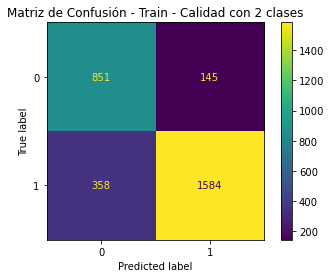

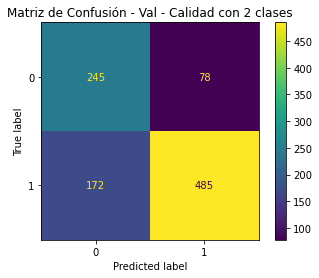

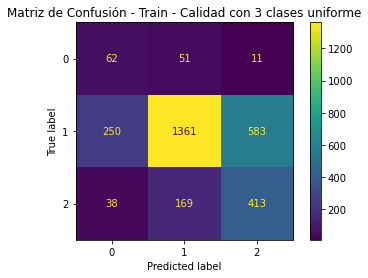

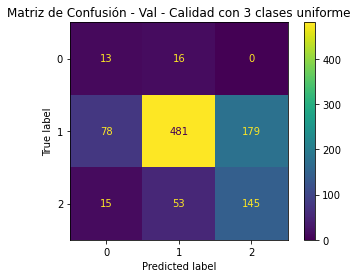

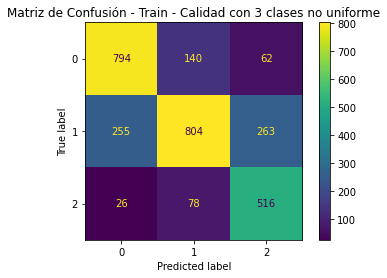

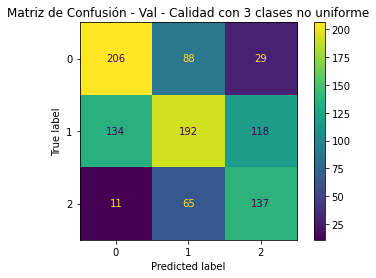

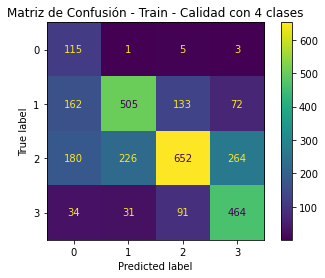

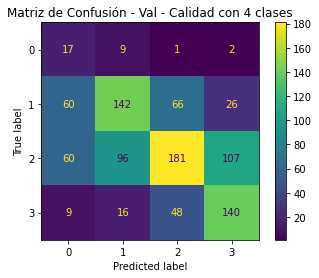

Wall time: 42.8 s


In [11]:
%%time
list_tree = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    tree_est = DecisionTreeClassifier(class_weight='balanced')

    dists = {'max_depth':range(2, 100),'min_samples_leaf': range(10, 1000)}

    tree = RandomizedSearchCV(tree_est, param_distributions = dists, n_iter=200, scoring='f1_macro')

    tree.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(tree, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(tree, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_tree.append([Y[0], 
                   f1_score(y_train, tree.predict(X_train), average='macro'),
                   f1_score(y_val, tree.predict(X_val), average='macro'),
                   accuracy_score(y_train, tree.predict(X_train)),
                   accuracy_score(y_val, tree.predict(X_val)),
                   f1_score(y_train, tree.predict(X_train), average=None),
                   f1_score(y_val, tree.predict(X_val), average=None)]
                   )

In [12]:
df_metrics_tree = pd.DataFrame(list_tree, columns=labels_metrics)
df_metrics_tree

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.3230,0.2571,0.3873,0.3418,"[0.097165991902834, 0.25938566552901027, 0.5180412371134021, 0.3919277748274031, 0.3941605839416...","[0.029411764705882356, 0.12087912087912087, 0.5094339622641509, 0.3444976076555024, 0.3641791044..."
1,Calidad con 2 clases,0.8174,0.7286,0.8288,0.7449,"[0.7718820861678004, 0.8629801144102425]","[0.6621621621621622, 0.7950819672131147]"
2,Calidad con 3 clases uniforme,0.4968,0.4932,0.6249,0.6520,"[0.26160337552742613, 0.7210596026490066, 0.5076828518746158]","[0.1925925925925926, 0.7468944099378882, 0.5400372439478586]"
3,Calidad con 3 clases no uniforme,0.7197,0.5498,0.7195,0.5459,"[0.766779333655239, 0.6860068259385664, 0.7063655030800823]","[0.6112759643916913, 0.48669201520912553, 0.5513078470824949]"
4,Calidad con 4 clases,0.5589,0.4418,0.5909,0.4898,"[0.3739837398373984, 0.6177370030581039, 0.5919201089423514, 0.6521433591004919]","[0.19428571428571428, 0.5098743267504489, 0.4891891891891892, 0.5737704918032788]"


# Métodos de Ensamble

## Random Forest

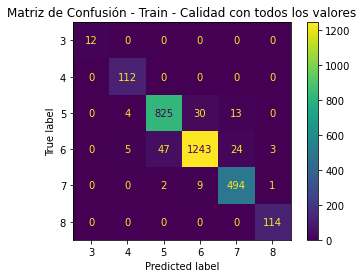

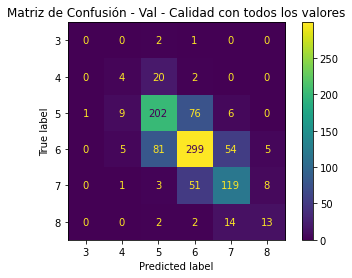

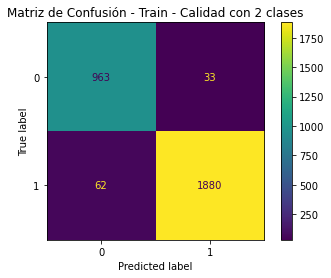

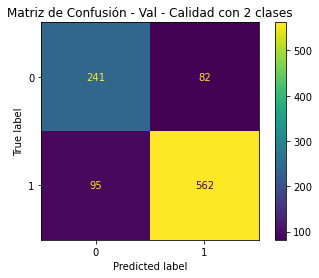

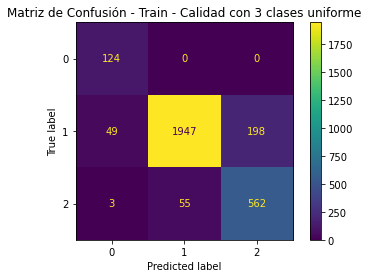

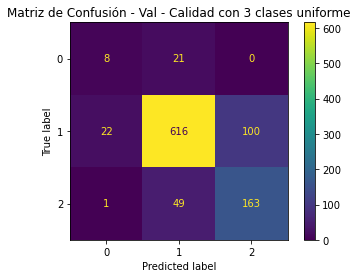

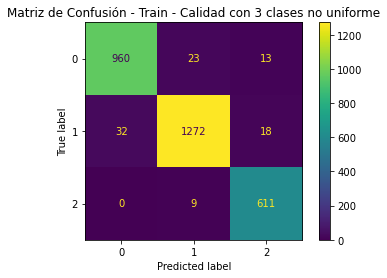

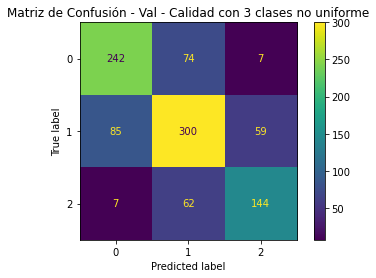

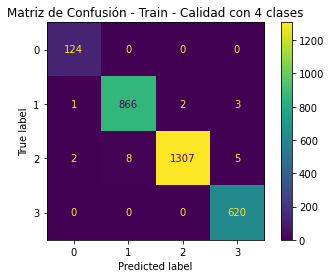

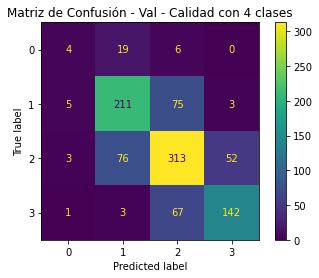

Wall time: 8min 54s


In [13]:
%%time
list_forest = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    forest_est = RandomForestClassifier(class_weight='balanced')

    dists = {'n_estimators':range(20, 100), 'max_depth':(2, 50), 'min_samples_leaf':range(2, 50)}
    
    forest = RandomizedSearchCV(forest_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    forest.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(forest, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(forest, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_forest.append([Y[0], 
                   f1_score(y_train, forest.predict(X_train), average='macro'),
                   f1_score(y_val, forest.predict(X_val), average='macro'),
                   accuracy_score(y_train, forest.predict(X_train)),
                   accuracy_score(y_val, forest.predict(X_val)),
                   f1_score(y_train, forest.predict(X_train), average=None),
                   f1_score(y_val, forest.predict(X_val), average=None)]
                   )

In [14]:
df_metrics_forest = pd.DataFrame(list_forest, columns=labels_metrics)
df_metrics_forest

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.9661,0.4368,0.9530,0.6500,"[1.0, 0.9613733905579399, 0.9450171821305842, 0.9546850998463902, 0.95274831243973, 0.9827586206...","[0.0, 0.17777777777777778, 0.6688741721854305, 0.6834285714285714, 0.6346666666666667, 0.4561403..."
1,Calidad con 2 clases,0.9642,0.7977,0.9677,0.8194,"[0.9529935675408214, 0.9753566796368353]","[0.731411229135053, 0.8639508070714835]"
2,Calidad con 3 clases uniforme,0.8564,0.6056,0.8962,0.8031,"[0.8266666666666667, 0.9280266920877026, 0.8144927536231884]","[0.26666666666666666, 0.8651685393258427, 0.6848739495798319]"
3,Calidad con 3 clases no uniforme,0.9676,0.6998,0.9677,0.7000,"[0.96579476861167, 0.9687738004569688, 0.9683042789223455]","[0.7366818873668189, 0.6818181818181819, 0.6808510638297872]"
4,Calidad con 4 clases,0.9918,0.5687,0.9929,0.6837,"[0.9880478087649402, 0.9919816723940436, 0.9935385784872672, 0.9935897435897436]","[0.1904761904761905, 0.6998341625207297, 0.6917127071823206, 0.6926829268292684]"


## Bagging de SVM

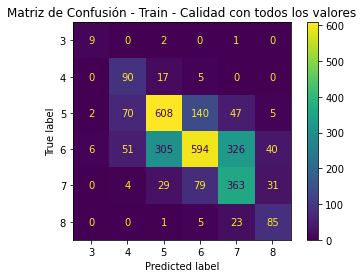

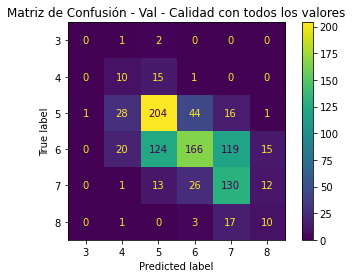

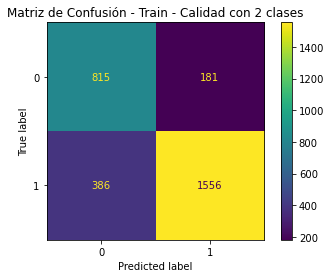

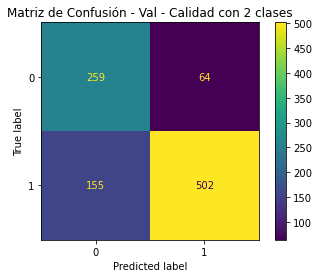

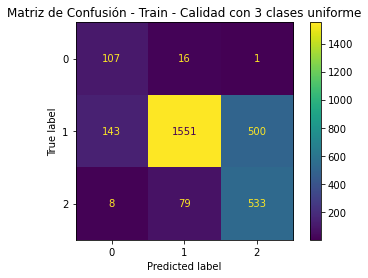

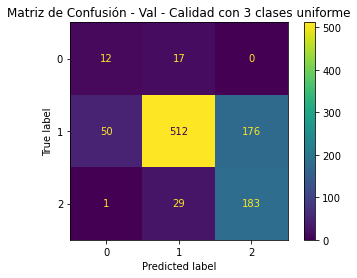

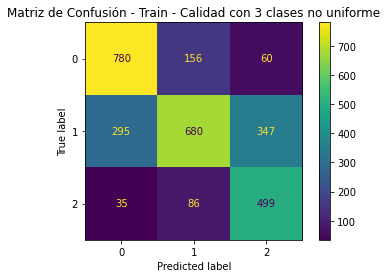

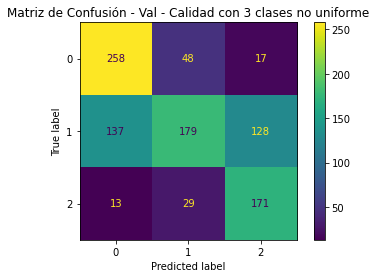

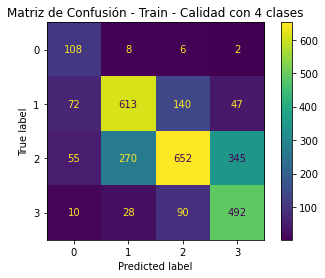

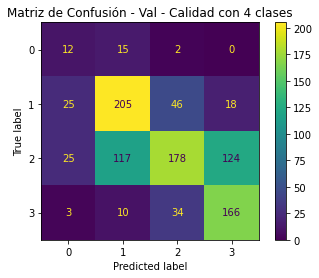

Wall time: 4h 10min 3s


In [15]:
%%time
list_svm_bag = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_bag_est = BaggingClassifier(base_estimator=SVC(kernel='rbf', C=10, gamma=0.05, class_weight='balanced'), max_samples=2/3)

    dists = {'n_estimators':range(20, 100)}
    
    svm_bag = GridSearchCV(svm_bag_est, param_grid = dists, scoring='f1_macro')

    svm_bag.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm_bag, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm_bag, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm_bag.append([Y[0], 
                   f1_score(y_train, svm_bag.predict(X_train), average='macro'),
                   f1_score(y_val, svm_bag.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm_bag.predict(X_train)),
                   accuracy_score(y_val, svm_bag.predict(X_val)),
                   f1_score(y_train, svm_bag.predict(X_train), average=None),
                   f1_score(y_val, svm_bag.predict(X_val), average=None)]
                   )

In [16]:
df_metrics_svm_bag = pd.DataFrame(list_svm_bag, columns=labels_metrics)
df_metrics_svm_bag

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.5966,0.3652,0.5953,0.5306,"[0.6206896551724139, 0.5504587155963302, 0.6630316248636859, 0.5538461538461539, 0.5734597156398...","[0.0, 0.22988505747126436, 0.6257668711656441, 0.4853801169590643, 0.5603448275862069, 0.2898550..."
1,Calidad con 2 clases,0.7939,0.7619,0.8070,0.7765,"[0.7419208010923987, 0.8458820331611853]","[0.7028493894165536, 0.820932134096484]"
2,Calidad con 3 clases uniforme,0.6708,0.5636,0.7457,0.7214,"[0.5602094240837696, 0.8078124999999999, 0.6444981862152357]","[0.26086956521739135, 0.7901234567901234, 0.6398601398601398]"
3,Calidad con 3 clases no uniforme,0.6669,0.6213,0.6668,0.6204,"[0.7407407407407408, 0.6060606060606062, 0.6539973787680211]","[0.7058823529411765, 0.5114285714285713, 0.6465028355387524]"
4,Calidad con 4 clases,0.6283,0.5095,0.6348,0.5724,"[0.5853658536585366, 0.6845337800111669, 0.5900452488687784, 0.6533864541832669]","[0.25531914893617025, 0.6396255850234009, 0.5056818181818182, 0.6372360844529751]"
